In [1]:
import requests
import zipfile
import os
import re
import numpy as np
import pandas as pd
import itertools
from collections import Counter
from tanglegram import tangle
import scipy.sparse
from scipy.spatial.distance import squareform, pdist, jaccard
from skbio.stats.distance import mantel
from sklearn.metrics import jaccard_similarity_score
import itertools
import multiprocessing
import seaborn as sns
from IPython.display import IFrame
%matplotlib inline

In [2]:
# download gnps network with node attributes and edge list
jobid = '9e1b636f7a2f4a909ee695a416c270f0'
url = "http://gnps.ucsd.edu/ProteoSAFe/DownloadResult?task=" + jobid + "&view=download_cluster_buckettable"

response = requests.post(url)

with open("download.zip", "wb") as output_file:
    for block in response.iter_content(1024):
        output_file.write(block)

In [2]:
if not os.path.exists('gnps_res'):
    os.mkdir('gnps_res')
    zip_ref = zipfile.ZipFile('download.zip', 'r') 
    zip_ref.extractall('gnps_res')
    zip_ref.close()

In [3]:
os.listdir('gnps_res/')

['clusterinfosummarygroup_attributes_withIDs_arbitraryattribute',
 'clusterinfo',
 'clusterinfogroup',
 'METABOLOMICS-SNETS-9e1b636f-download_cluster_buckettable-main.tsv',
 'clusterinfosummary',
 'groupmapping_converted',
 'result_specnets_DB',
 'clusterinfosummarygroup_attributes_withIDs_withcomponentID',
 'clusterinfosummarygroup_attributes',
 'networkedges',
 'clusterinfosummarygroup_attributes_withIDs',
 'params.xml',
 'clusterinfosummarygroup',
 'networkedges_selfloop']

In [4]:
tabgnps = pd.read_table('gnps_res/clusterinfosummarygroup_attributes_withIDs/56c55f410b6e4e6ebd116f26e84ca939..out')
tabgnps.head()

,cluster index,number of spectra,parent mass,precursor charge,precursor mass,sum(precursor intensity),G1,G2,G3,G4,...,AllGroups,DefaultGroups,RTMean,RTStdErr,ProteoSAFeClusterLink,UniqueFileSourcesCount,EvenOdd,LibraryID,NumberOrganismIDs,AllOrganisms
0,586,18,125.718,0,125.718,27644.0,18,0,0,0,...,,"G1,",110.672833,26.496832,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,18,0,2-Chloro-6-fluorobenzyl alcohol,1,NIST17;
1,587,2,125.985,0,125.985,2144.0,2,0,0,0,...,,"G1,",131.231000,18.200929,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,2,0,"3,4-Dimethoxyphenylacetic acid",1,NIST17;
2,590,86,129.110,0,129.110,116828.0,86,0,0,0,...,,"G1,",103.428116,31.064889,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,72,0,Guaiacol methyl ether,1,NIST17;
3,595,11,129.288,0,129.288,12200.0,11,0,0,0,...,,"G1,",115.607818,27.997418,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,11,0,"2-Propanone, 1-(3-ethyl-5-methoxy-2(3H)-benzot...",1,NIST17;
4,599,18,129.434,0,129.434,26576.0,18,0,0,0,...,,"G1,",112.253222,35.546967,http://gnps.ucsd.edu//ProteoSAFe/result.jsp?ta...,18,0,"2,5-Dimethoxy-4-ethylphenethylamine",1,NIST17;


In [5]:
# Create a presence/absence matrix with all clustered spectra
# and all samples
def getSampID(fname):
    return [re.sub('\.mzXML.+$', '', x) for x in fname.split('###') if x!='']

fnames = tabgnps['AllFiles'].apply(getSampID)
usamp = np.array(list(set(list(itertools.chain.from_iterable(fnames)))))
idx = fnames.apply(lambda a: set([np.where(usamp==b)[0][0] for b in a])) 
prod = [(x, y) for x in range(len(idx)) for y in list(idx[x])] 

In [6]:
len(usamp)

524

In [7]:
r = [x for (x, y) in prod] # x_coordinate
c = [y for (x, y) in prod] # y_coordinate
data = [1] * len(r)
m = scipy.sparse.coo_matrix((data, (r, c)), shape=(tabgnps.shape[0], len(usamp)))

In [8]:
s = m.todense()

ridx = np.array(tabgnps.index)
ridx.shape = (tabgnps.shape[0], 1)
s = np.append(ridx, s, 1)

In [9]:
# Save the matrix with sample names in the first row for biom convertion
s = pd.DataFrame(s)
s.columns = ['#SampID']+usamp.tolist()
s.to_csv('feat_table.tsv', index=None, sep='\t')

In [10]:
s.shape

(23847, 525)

In [11]:
# Load the edge list from GNPS network to cluster compounds by network cluster
net = pd.read_table('gnps_res/networkedges_selfloop/2d681c7f31d34166a89444e377809baf.pairsinfo')
net.head()

,CLUSTERID1,CLUSTERID2,DeltaMZ,MEH,Cosine,OtherScore,ComponentIndex
0,1526268,1538108,-190.917000,0.0,0.932495,0.761121,3
1,1281050,1281169,-0.351990,0.0,0.967102,0.687290,3
2,1524498,1526818,-44.025000,0.0,0.950863,0.778453,3
3,1289009,1322419,-30.958000,0.0,0.923895,0.572155,3
4,1526268,1526394,-0.754028,0.0,0.978512,0.861647,3


In [12]:
# skip sampID header tag
smolfamily = s[s.columns[1:]]
smolfamily.index = list(tabgnps['cluster index'])
smolfamily.shape

(23847, 524)

In [13]:
# set of unique connected componets, including single nodes
ucomp = list(set(net['ComponentIndex']))
len(ucomp)

2515

In [14]:
# cluster molecules, such that, if the at least one node
# of the connected component is present in a sample
# the sample has 1 assigned 
rowlist = []

for i in range(len(ucomp)):
    uidx = list(set(list(net[net['ComponentIndex']==ucomp[i]]['CLUSTERID1'])+
                list(net[net['ComponentIndex']==ucomp[i]]['CLUSTERID2'])
                )
           )
    rowlist.append(smolfamily.loc[uidx].apply(lambda a: 1 if sum(a)>0 else 0))

In [15]:
s2 = pd.concat(rowlist, axis=1).T

In [18]:
# Can't match all ids with summary_list_2.txt below
gcf_df = pd.read_csv('gcf_map_binary.txt', sep='\t')
header = list(gcf_df.columns.values)
gcf_df.index.names = ['GCFs']

ids = gcf_df.columns.astype(str).tolist()
data = gcf_df.as_matrix()
data = data.transpose()
data = data.astype(int)

#bc_dm = beta_diversity("braycurtis", data, ids)
#bc_dm_df = bc_dm.to_data_frame()

In [19]:
gcf_df.head()

,1A3,1A7,1B1,1B6,1C2,1C4,1D4,1D5,1D6,1D7,...,NHHE01,NHHS01,NHIA01,NHII01,NHIK01,NHIL01,NHJC01,NHJU01,NHKA01,NKFP01
GCFs,,,,,,,,,,,,,,,,,,,,,
0,1,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
cn = [x for x in gcf_df.columns if len(x)==3]
len(cn)

95

In [21]:
meta = pd.read_table('summary_list_2.txt')
meta['File'] = [re.sub('\.d$', '', str(x)) for x in meta['File']]
meta.head()

,Unnamed: 0,Fraction,Plate,Code,Locus,File
0,0,Crude,001G1,PNG21MAY054ENV,2F1,1557_001G1_RG1_01_12567
1,1,A,001G2,PNG21MAY054ENV,2F1,1557_001G2_RG2_01_12568
2,2,B,001G3,PNG21MAY054ENV,2F1,1557_001G3_RG3_01_12569
3,3,C,001G4,PNG21MAY054ENV,2F1,1557_001G4_RG4_01_12570
4,4,D,001G5,PNG21MAY054ENV,2F1,1557_001G5_RG5_01_12571


In [22]:
# Match two letter id of metadata table with three letter id gene cluster table
present_cn_absent_locus = np.array(list(set(cn)-set(meta['Locus'])))
present_locus_absent_cn = np.array(list(set(meta['Locus'])-set(cn)))

mpos = [np.where(present_locus_absent_cn==re.sub('^.{1}', '', x)) for x in present_cn_absent_locus]

In [23]:
cn = np.array(cn)
for i in range(len(present_cn_absent_locus)):
    if len(mpos[i][0]):
        cn[cn==present_cn_absent_locus[i]] = re.sub('^.{1}', '', present_cn_absent_locus[i])

In [24]:
dcn = pd.DataFrame(cn, columns=['gene_id'])
dcn.head()

,gene_id
0,1A3
1,1A7
2,B1
3,B6
4,1C2


In [25]:
# Remove 4 number at beginning and space from MS file name 
usamp2 = [re.sub('^\d+ ', '', x) for x in usamp]
matching_ids = pd.merge(pd.DataFrame(usamp2), meta, left_on=0, right_on='File')
matching_ids.shape

(521, 7)

In [26]:
np.array(list(set(usamp)-set(matching_ids['File'])))

array(['2041 G_GD3_01_37759', '2043 cr_GD6_01_37762',
       '2041 I_GD5_01_37761', '2216 C_GF5_01_37785',
       '2122 cr_GF1_01_37781', 'Solvent_blank_GH11_01_37732',
       '1506 cr_GC11_01_37755', '2216 D_GF6_01_37786',
       '2210 cr_GF3_01_37783', 'QC_GH12_01_37803', '1500 cr_GC8_01_37752',
       'Solvent_blank_GH11_01_37792', '2080 cr_GE2_01_37770',
       '2235 cr_GF11_01_37791', '1492 cr_GC7_01_37751',
       '2083 cr_GE3_01_37771', '2246 cr_GG3_01_37795',
       '2103 cr_GE7_01_37775', 'Solvent_blank_GH11_01_37756',
       '2216 cr_GF4_01_37784', '2041 H_GD4_01_37760',
       'Solvent_blank_GH11_01_37780', '2035 cr_GD1_01_37757',
       '2069 F_GD10_01_37766', 'Solvent_blank_GH11_01_37802',
       '2209 cr_GE11_01_37779', '2086 cr_GE4_01_37772',
       'SS12JAN13_10_C_GB11_01_37743', '2216 I_GF7_01_37787',
       '2248 cr_GC6_01_37750', '2111 cr_GE8_01_37776',
       '2046 cr_GD7_01_37763', '2247 cr_GG4_01_37796',
       '2200 cr_GE10_01_37778', '2203 cr_GE9_01_37777',
    

In [27]:
np.array(list(set(usamp2)-set(matching_ids['File'])))

array(['Solvent_blank_GH11_01_37768', 'Solvent_blank_GH11_01_37780',
       'QC_GH12_01_37803', 'Solvent_blank_GH11_01_37802',
       'Solvent_blank_GH11_01_37792', 'SS12JAN13_10_C_GB11_01_37743',
       'QC_GH12_01_37720', 'Solvent_blank_GH11_01_37719',
       'Solvent_blank_GH11_01_37756', 'Solvent_blank_GH11_01_37732',
       'Solvent_blank_GH11_01_37744'],
      dtype='<U28')

In [28]:
matching_ids2 = pd.merge(dcn, matching_ids, left_on='gene_id', right_on='Locus')
matching_ids2.shape

(152, 8)

In [29]:
# Number of gene cluster ids matching with redundancy
len(set(matching_ids2['Locus']))

50

In [30]:
s2.columns = [re.sub('^\d+ ', '', x) for x in s2.columns]

In [31]:
# Collapse all MS sample (extract plus fractions) in one sample matching gene cluster
# If crude equals to 1, select only the crude extract when present 
ulocus = list(set(matching_ids2['Locus']))
slist = []
cnlist = []
mlist = []
crude = 0
# for debugging
# c = 0

for locus in ulocus:
    tmp = matching_ids2.loc[matching_ids2['Locus']==locus]
    tmp.reset_index(inplace=True, drop=True)
    if crude == 1 and sum(tmp['Fraction'].str.contains("crude", case=False)):
        tmp = tmp.loc[tmp['Fraction'].str.contains("crude", case=False)]

    if sum(tmp['Fraction'].str.contains("crude", case=False)):
        stmp = s2[tmp['File']].apply(lambda a: 1 if sum(a)>0 else 0, axis=1)
        tmp = tmp.loc[tmp['Fraction'].str.contains("crude", case=False)]
        tmp.drop_duplicates(subset=['Locus', 'File'], inplace=True)
        cnlist.append(list(tmp['File'])[0])
        mlist.append(tmp)
        slist.append(stmp)
        # for debugging
        #print((c,tmp.shape[0]))
        #c += 1
    else:
        stmp = s2[tmp['File']].apply(lambda a: 1 if sum(a)>0 else 0, axis=1)
        tmp = tmp.loc[[0]]
        cnlist.append(list(tmp['File'])[0])
        mlist.append(tmp)
        slist.append(stmp)
        # for debugging
        #print((c,tmp.shape[0]))
        #c += 1

In [32]:
metab = pd.concat(slist, axis=1)
metab.columns = cnlist
metab.head()

,1920_025F9_RF9_01_15025,1869_022D3_GD3_01_14676,1889_024A3_GA3_01_14835,3L_MooreaB_C_GA1_01_37721,H_GD9_01_37765,A1831_018A6_GA6_01_14226,1872_022F10_GF10_01_14718,PRM24MAR11_10_C_GB10_01_37742,PAL23MAY13_1_C_GB1_01_37733,1700_011E8_RE8_01_13552,...,cr_GG4_01_37796,PAL24MAY13_5-contA_C_GB6_01_37738,1894_024C4_GC4_01_14864,DMSO_1752_014B12_GB12_01_13869,C15-B cr_GG7_01_37799,cr_GF2_01_37782,cr_GG3_01_37795,PAL24MAY13_4_C_GB4_01_37736,1902_024H11_GH11_01_14948,cr_GC6_01_37750
0,1,1,0,0,1,1,1,0,1,1,...,1,0,0,1,1,0,1,0,1,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
metaidx = pd.concat(mlist)
metaidx.head()

,gene_id,0,Unnamed: 0,Fraction,Plate,Code,Locus,File
2,I9,1920_025F9_RF9_01_15025,398,Crude,025F9,NAC12DEC082ENV,I9,1920_025F9_RF9_01_15025
8,3A9,1869_022D3_GD3_01_14676,256,Crude,022D3,NAC21DEC083ENV,3A9,1869_022D3_GD3_01_14676
0,2G6,1889_024A3_GA3_01_14835,314,Crude,024A3,PAL22AUG082ENV,2G6,1889_024A3_GA3_01_14835
0,4B7,3L_MooreaB_C_GA1_01_37721,508,crude,035A2,3LMooreaBCUL,4B7,3L_MooreaB_C_GA1_01_37721
0,F9,H_GD9_01_37765,477,H,None,PRL23MAR11-1ENV,F9,H_GD9_01_37765


In [34]:
# Exclude redundant sample names
metaidx.query('Locus!="F2" and Locus!="I9"').shape

(48, 8)

In [35]:
gcf_df2 = gcf_df[gcf_df.columns[[len(x)==3 for x in gcf_df.columns]]]
gcf_df2.columns = cn
gcf_df2 = gcf_df2[metaidx['Locus']]
gcf_df2 = pd.concat([pd.DataFrame(list(range(gcf_df2.shape[0])), columns=['#SampleID']), gcf_df2], axis=1)
gcf_df2.head()

,#SampleID,I9,I9,3A9,2G6,4B7,F9,2D2,2G5,G5,...,4G3,I4,2G7,3B5,4C5,C8,4G2,D4,3A5,B1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
4,4,0,1,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,0,0,0


In [36]:
metab = pd.concat([pd.DataFrame(list(ucomp), columns=['#SampleID']), metab], axis=1)
metab.head()

,#SampleID,1920_025F9_RF9_01_15025,1869_022D3_GD3_01_14676,1889_024A3_GA3_01_14835,3L_MooreaB_C_GA1_01_37721,H_GD9_01_37765,A1831_018A6_GA6_01_14226,1872_022F10_GF10_01_14718,PRM24MAR11_10_C_GB10_01_37742,PAL23MAY13_1_C_GB1_01_37733,...,cr_GG4_01_37796,PAL24MAY13_5-contA_C_GB6_01_37738,1894_024C4_GC4_01_14864,DMSO_1752_014B12_GB12_01_13869,C15-B cr_GG7_01_37799,cr_GF2_01_37782,cr_GG3_01_37795,PAL24MAY13_4_C_GB4_01_37736,1902_024H11_GH11_01_14948,cr_GC6_01_37750
0,3,1,1,0,0,1,1,1,0,1,...,1,0,0,1,1,0,1,0,1,1
1,4,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8198,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
metaidx.tail()

,gene_id,0,Unnamed: 0,Fraction,Plate,Code,Locus,File
0,C8,cr_GF2_01_37782,489,crude,035F9,SPB31JAN13-9ENV,C8,cr_GF2_01_37782
0,4G2,cr_GG3_01_37795,504,crude,035G6,GBB21MAR16-1ENV,4G2,cr_GG3_01_37795
0,D4,PAL24MAY13_4_C_GB4_01_37736,530,crude,035C1,PAL24MAY13-4CUL,D4,PAL24MAY13_4_C_GB4_01_37736
6,3A5,1902_024H11_GH11_01_14948,357,Crude,024H1,NAC18DEC082ENV,3A5,1902_024H11_GH11_01_14948
0,B1,cr_GC6_01_37750,506,crude,None,ASF14JUL14-2ENV,B1,cr_GC6_01_37750


In [38]:
gcf_df2.drop(['I9', 'F2'], inplace=True, axis=1)
metab.drop(['1920_025F9_RF9_01_15025', 'cr_GG1_01_37793'], inplace=True, axis=1)

metab.columns = gcf_df2.columns

metab.to_csv('metabolome_for_comparison.txt', index=None, sep='\t')
gcf_df2.to_csv('metagenome_for_comparison.txt', index=None, sep='\t')

mapping = pd.DataFrame()
mapping['#SampleID'] = metab.columns[1:]
mapping['BarcodeSequence'] = "GATACA" 
mapping['LinkerPrimerSequence'] = "GATACA"
mapping['CLASS'] = "dummy"
mapping['Description'] = "Metabolome"
mapping.to_csv('mapping_file_comparison.txt', index=None, sep='\t')
mapping.head()

,#SampleID,BarcodeSequence,LinkerPrimerSequence,CLASS,Description
0,3A9,GATACA,GATACA,dummy,Metabolome
1,2G6,GATACA,GATACA,dummy,Metabolome
2,4B7,GATACA,GATACA,dummy,Metabolome
3,F9,GATACA,GATACA,dummy,Metabolome
4,2D2,GATACA,GATACA,dummy,Metabolome


In [39]:
metab.shape

(2515, 49)

In [40]:
gcf_df2.shape

(350, 49)

In [41]:
# Exclude redundant sample names
metaidx.query('Locus!="F2" and Locus!="I9"').to_csv('matching_metagenome_metabolome_samples.txt', index=None, sep='\t')

### Metabolome clustering

In [42]:
!/home/sm2/anaconda2/envs/qiime1/bin/beta_diversity.py -s

Known metrics are: abund_jaccard, binary_chisq, binary_chord, binary_euclidean, binary_hamming, binary_jaccard, binary_lennon, binary_ochiai, binary_otu_gain, binary_pearson, binary_sorensen_dice, bray_curtis, bray_curtis_faith, bray_curtis_magurran, canberra, chisq, chord, euclidean, gower, hellinger, kulczynski, manhattan, morisita_horn, pearson, soergel, spearman_approx, specprof, unifrac, unifrac_g, unifrac_g_full_tree, unweighted_unifrac, unweighted_unifrac_full_tree, weighted_normalized_unifrac, weighted_unifrac



In [43]:
!/home/sm2/anaconda2/envs/qiime1/bin/biom convert -i metabolome_for_comparison.txt -o metabolome_for_comparison.biom --to-hdf5 --table-type 'Metabolite table'

In [44]:
!/home/sm2/anaconda2/envs/qiime1/bin/beta_diversity.py -i metabolome_for_comparison.biom -m binary_jaccard -o metabolome_for_comparison_binary_jaccard

/home/sm2/anaconda2/envs/qiime1/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [45]:
!/home/sm2/anaconda2/envs/qiime1/bin/principal_coordinates.py -i metabolome_for_comparison_binary_jaccard/binary_jaccard_metabolome_for_comparison.txt -o metabolome_for_comparison_coords.txt

In [46]:
!/home/sm2/anaconda2/envs/qiime1/bin/make_emperor.py -i metabolome_for_comparison_coords.txt -m mapping_file_comparison.txt -o emperor_output_metabolome

In [47]:
%%HTML
<iframe width="100%" height="350" src="emperor_output_metabolome/index.html"></iframe>

In [48]:
!zip -r emperor_output_metabolome.zip emperor_output_metabolome/

  adding: emperor_output_metabolome/ (stored 0%)
  adding: emperor_output_metabolome/index.html (deflated 76%)
  adding: emperor_output_metabolome/emperor_required_resources/ (stored 0%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/ (stored 0%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/ (stored 0%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/animate.js (deflated 68%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/draw.js (deflated 54%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/trajectory.js (deflated 71%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/util.js (deflated 60%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/emperor.js (deflated 77%)
  adding: emperor_output_metabolome/emperor_required_resources/emperor/js/ui.js (deflated 54%)
  adding: emperor_output_metabolome/emperor_requir

### Genome clustering

In [49]:
!/home/sm2/anaconda2/envs/qiime1/bin/biom convert -i metagenome_for_comparison.txt -o metagenome_for_comparison.biom --to-hdf5 --table-type 'Metabolite table'

In [50]:
!/home/sm2/anaconda2/envs/qiime1/bin/beta_diversity.py -i metagenome_for_comparison.biom -m binary_jaccard -o metagenome_for_comparison_binary_jaccard

/home/sm2/anaconda2/envs/qiime1/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2645: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


In [51]:
!/home/sm2/anaconda2/envs/qiime1/bin/principal_coordinates.py -i metagenome_for_comparison_binary_jaccard/binary_jaccard_metagenome_for_comparison.txt -o metagenome_for_comparison_coords.txt

/home/sm2/anaconda2/envs/qiime1/lib/python2.7/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:107: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.04500732927 and the largest is 3.33598299073.
  RuntimeWarning


In [52]:
!/home/sm2/anaconda2/envs/qiime1/bin/make_emperor.py -i metagenome_for_comparison_coords.txt -m mapping_file_comparison.txt -o emperor_output_metagenome

In [53]:
%%HTML
<iframe width="100%" height="350" src="emperor_output_metagenome/index.html"></iframe>

In [54]:
!zip -r emperor_output_metagenome.zip emperor_output_metagenome/

  adding: emperor_output_metagenome/ (stored 0%)
  adding: emperor_output_metagenome/index.html (deflated 78%)
  adding: emperor_output_metagenome/emperor_required_resources/ (stored 0%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/ (stored 0%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/ (stored 0%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/animate.js (deflated 68%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/draw.js (deflated 54%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/trajectory.js (deflated 71%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/util.js (deflated 60%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/emperor.js (deflated 77%)
  adding: emperor_output_metagenome/emperor_required_resources/emperor/js/ui.js (deflated 54%)
  adding: emperor_output_metagenome/emperor_requir

### Procrustes

In [55]:
!/home/sm2/anaconda2/envs/qiime1/bin/transform_coordinate_matrices.py -i metagenome_for_comparison_coords.txt,metabolome_for_comparison_coords.txt -r 999 -o procrustes_results/

In [56]:
# See the manual for how to interpret the p-value and M2
# http://qiime.org/tutorials/procrustes_analysis.html
!/home/sm2/anaconda2/envs/qiime1/bin/make_emperor.py -c -i procrustes_results/ -o procrustes_results/plots/ -m mapping_file_comparison.txt

In [57]:
%%HTML
<iframe width="100%" height="350" src="procrustes_results/plots/index.html"></iframe>

In [58]:
!zip -r procrustes_results.zip procrustes_results/

  adding: procrustes_results/ (stored 0%)
  adding: procrustes_results/procrustes_results.txt (deflated 30%)
  adding: procrustes_results/metagenome_for_comparison_coords_transformed_reference.txt (deflated 59%)
  adding: procrustes_results/metabolome_for_comparison_coords_transformed_q1.txt (deflated 51%)
  adding: procrustes_results/plots/ (stored 0%)
  adding: procrustes_results/plots/index.html (deflated 77%)
  adding: procrustes_results/plots/emperor_required_resources/ (stored 0%)
  adding: procrustes_results/plots/emperor_required_resources/emperor/ (stored 0%)
  adding: procrustes_results/plots/emperor_required_resources/emperor/js/ (stored 0%)
  adding: procrustes_results/plots/emperor_required_resources/emperor/js/animate.js (deflated 68%)
  adding: procrustes_results/plots/emperor_required_resources/emperor/js/draw.js (deflated 54%)
  adding: procrustes_results/plots/emperor_required_resources/emperor/js/trajectory.js (deflated 71%)
  adding: procrustes_results/plots/emperor

In [82]:
mmetab = metab[metab.columns[1:]].T
mat1 = squareform(pdist(mmetab, 'jaccard'))
mat1 = pd.DataFrame(mat1, columns=mmetab.index, index=mmetab.index)

In [83]:
mgcf_df2 = gcf_df2[gcf_df2.columns[1:]].T
mat2 = squareform(pdist(mgcf_df2, 'jaccard'))
mat2 = pd.DataFrame(mat2, columns=mgcf_df2.index, index=mgcf_df2.index)

In [84]:
#http://scikit-bio.org/docs/0.1.3/generated/skbio.math.stats.distance.mantel.html
mantel(mat1.as_matrix(),mat2.as_matrix())

(0.026842431374806922, 0.69999999999999996, 48)

/home/sm2/anaconda2/envs/gnps/lib/python3.6/site-packages/tanglegram/tangle.py:76: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage1 = sclust.hierarchy.linkage(a, **kwargs)
/home/sm2/anaconda2/envs/gnps/lib/python3.6/site-packages/tanglegram/tangle.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage2 = sclust.hierarchy.linkage(b, **kwargs)
Optimizing: 100%|██████████| 10000/10000 [00:18<00:00, 549.19it/s]
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


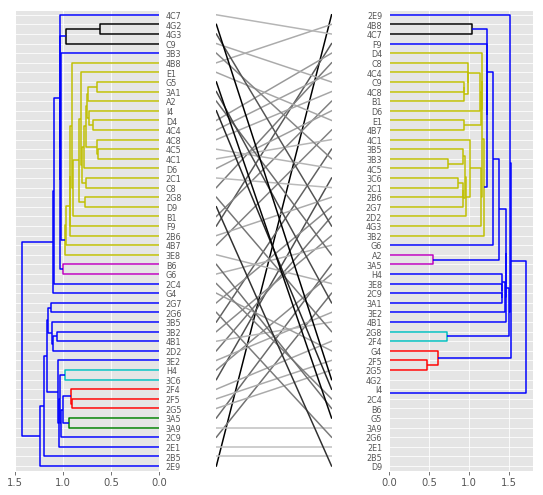

In [85]:
fig = tangle.plot(mat1,mat2)
#plt.show()

In [63]:
metab.head()

,#SampleID,3A9,2G6,4B7,F9,2D2,2G5,G5,2G8,2E1,...,4G3,I4,2G7,3B5,4C5,C8,4G2,D4,3A5,B1
0,3,1,0,0,1,1,1,0,1,1,...,1,0,0,1,1,0,1,0,1,1
1,4,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,8198,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [64]:
gcf_df2.head()

,#SampleID,3A9,2G6,4B7,F9,2D2,2G5,G5,2G8,2E1,...,4G3,I4,2G7,3B5,4C5,C8,4G2,D4,3A5,B1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,1,1,1,1,1,1,1,0,1,...,1,1,1,1,1,1,1,1,1,1
4,4,0,0,0,0,0,0,0,1,0,...,0,0,0,1,1,0,0,0,0,0


In [65]:
# Generate all combinations of two vectors
#idxlist = list(itertools.product(list(meta.index), list(gcf_df2.index)))
idxlist = [(x,y) for x in list(metab.index) for y in list(gcf_df2.index)]
idxlist[:5]

[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4)]

In [66]:
# define a function to calculate similarity score 
# (distance could be also used, in that case we should aim to 0 distance)
def myjaccard(idxtuple):
    return jaccard_similarity_score(metab.iloc[idxtuple[0]][1:], gcf_df2.iloc[idxtuple[1]][1:])

In [67]:
pool = multiprocessing.Pool(4)
out = pool.map(myjaccard, idxlist)

/home/sm2/anaconda2/envs/gnps/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


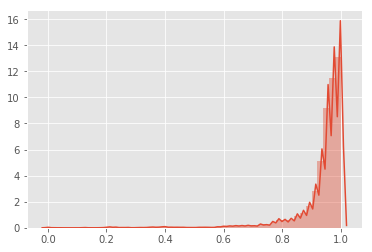

In [68]:
# Calculate all pairwise jaccard similarities of gene clusters VS metabolite clusters
sns.distplot(pd.DataFrame(out).dropna());

In [69]:
# Get the index of gene and metabolite cluster that 
# have perfect correspondence in samples
# We can also change the selection changing the criteria 
# to out[o]>0.9 for example
metidx = []
genidx = []
for o in range(len(out)):
    if out[o]==1:
        metidx.append(idxlist[o][0])
        genidx.append(idxlist[o][1])

metidx = list(set(metidx))
genidx = list(set(genidx))

In [90]:
# Select the indexes and remove metabolites that are
# zero in all samples
mmetab = metab.iloc[metidx][metab.columns[1:]].T
mmetab = mmetab[mmetab.columns[mmetab.apply(lambda a: sum(a)!=0)]]

In [91]:
# Select the indexes and remove genes that are
# zero in all samples
mgcf_df2 = gcf_df2.iloc[genidx][gcf_df2.columns[1:]].T
mgcf_df2 = mgcf_df2[mgcf_df2.columns[mgcf_df2.apply(lambda a: sum(a)!=0)]]

In [92]:
# Find samples that have all zeros for selected metabolites
mmsamp = mmetab.apply(lambda a: sum(a)!=0, axis=1)
mgsamp = mgcf_df2.apply(lambda a: sum(a)!=0, axis=1)
nzerosamp = pd.concat([mmsamp, mgsamp], axis=1).apply(lambda a: sum(a)==2, axis=1)
nzerosamp = [x for x in range(len(nzerosamp)) if nzerosamp[x]]

In [93]:
mmetab = mmetab.iloc[nzerosamp]
mgcf_df2 = mgcf_df2.iloc[nzerosamp]

In [94]:
mgcf_df2.shape

(23, 45)

In [95]:
mmetab.shape

(23, 163)

In [96]:
mat1 = squareform(pdist(mmetab, 'jaccard'))
mat1 = pd.DataFrame(mat1, columns=mmetab.index, index=mmetab.index)

mat2 = squareform(pdist(mgcf_df2, 'jaccard'))
mat2 = pd.DataFrame(mat2, columns=mgcf_df2.index, index=mgcf_df2.index)

In [97]:
#http://scikit-bio.org/docs/0.1.3/generated/skbio.math.stats.distance.mantel.html
mantel(mat1.as_matrix(),mat2.as_matrix())

(0.99230176352718036, 0.001, 23)

/home/sm2/anaconda2/envs/gnps/lib/python3.6/site-packages/tanglegram/tangle.py:76: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage1 = sclust.hierarchy.linkage(a, **kwargs)
/home/sm2/anaconda2/envs/gnps/lib/python3.6/site-packages/tanglegram/tangle.py:86: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage2 = sclust.hierarchy.linkage(b, **kwargs)
Optimizing: 100%|██████████| 10000/10000 [00:09<00:00, 1053.72it/s]
INFO  : Done. Use matplotlib.pyplot.show() to show plot. (tanglegram.tangle)


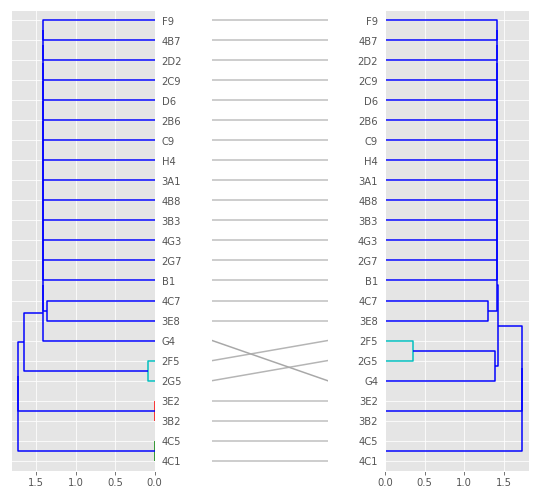

In [98]:
fig = tangle.plot(mat1,mat2)
#plt.show()

In [100]:
mmetab.apply(lambda a: sum(a))

2       1
2051    1
2058    1
26      1
41      1
2091    1
2118    1
2120    1
91      1
2137    2
99      1
100     1
109     1
114     1
128     1
135     1
2181    1
2185    1
151     1
152     1
2201    1
182     2
186     2
2236    2
2239    2
2243    1
202     1
2254    1
2258    2
220     1
       ..
1667    1
1671    1
1676    1
1697    1
1714    1
1716    1
1728    1
1732    1
1775    1
1783    2
1792    1
1825    1
1838    1
1844    1
1849    1
1865    1
1897    1
1902    1
1922    1
1932    1
1944    1
1958    1
1966    1
1969    1
1976    1
1980    1
2011    1
2012    1
2015    1
2016    2
Length: 163, dtype: int64

In [102]:
mgcf_df2.apply(lambda a: sum(a))

2      1
5      1
6      1
13     1
15     1
23     1
25     1
26     1
28     1
29     1
30     1
31     1
32     1
33     1
34     1
35     1
36     1
39     1
43     2
44     1
46     2
47     2
50     2
51     2
55     1
61     1
70     2
71     1
72     1
73     1
74     1
75     2
76     1
77     1
78     1
79     1
80     1
81     1
100    2
102    1
103    1
106    1
107    1
110    1
112    1
dtype: int64